## 0. Introduction

This file covers all parts related to the initial data explorations that are part of our defined research questions. The purpose of that is to dig deeper into data distributions and querying subtleties of the cleaned datasets. Subsequent in-depth analysis will follow in Milestone 3. The following parts are pre-requisites of this exploration and were done separately:

1. Dataset transformation and cleaning:

- Extraction of historical events from Wikipedia Timelines (`scripts/extract_wikipedia_timelines.ipynb`) 
- IMDb dataset extraction and merging with the main CMU movies dataset (`scripts/merge_imdb_with_cmu.ipynb`)
- Merging CMU movies with their summaries (`scripts/merge_movies_with_summaries.ipynb`)

2. Utility methods and functions to fetch structured Google Search Trends data:

- Functions to analyze movie genres and their distributions (`utils/genres.py`)
- Methods to fetch Google Trends data for given timelines and keywords (`utils/google_trends.py`)

In [1]:
import pandas as pd
import plotly.express as px
from collections import Counter
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.genres import *
from src.utils.genres import name_plot, count_genre_over_years, top_years_for_genre, bottom_years_for_genre, count_genres_by_year, calc_genre_differences, calc_genre_growth, calc_proportion_growth
import warnings
import csv
import re
# %pip install nltk
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ne_chunk
from nltk.sentiment import SentimentIntensityAnalyzer
from src.utils import google_trends as gt
from data.Cleaning import final_df
warnings.simplefilter("ignore")
from ast import literal_eval
import plotly.graph_objects as go 

ModuleNotFoundError: No module named 'dotenv'

## 1. Research Question 1

How do global crises and significant world events shape the production, themes, and budget allocations of movies?

In [2]:
# Import data
data = pd.read_csv("data/filtered_movie_data.csv")
df = pd.DataFrame(data)

Here I would like to explore the genres released throughout the Vietnam War. The war lasted from 1959 to 1975, so I have chosen to comapre those years with the middle of the war - 1967, plus years 1957 and 1977. Note that the Civil War in Vietnam started in 1957, while America joined in 1959. The year of 1967 was included as the middle of the war for comparison, and the year 1977 was included to see how the genre production changed after the war had ended and two years have passed. First, I calculate the 30 most popular genres during each year.

The War Films genre stays in the top 30 throught all of the years, even though its popularity decreases over time. Interestingly, the Spy genre enters the top in 1967 and is two places ahead of War Films, however, is disappears from the top after.

In [ ]:
# Initialize years and datafraes for genre counts for each
'''
vietnam_war_rows = final_df[final_df['WarName'].str.contains('Vietnam War', case=False, na=False)].iloc[0]
year1 = vietnam_war_rows["StartYear"]
year3 = vietnam_war_rows["EndYear"]
year0 = year1 - 2
year2 = (year1 + year3) // 2
year4 = year3 + 2
'''

year0, year1, year2, year3, year4 = 1957, 1959, 1967, 1975, 1977

counts_year0, total_movies_year0 = count_genres_by_year(df, year0)
counts_year1, total_movies_year1 = count_genres_by_year(df, year1)
counts_year2, total_movies_year2 = count_genres_by_year(df, year2)
counts_year3, total_movies_year3 = count_genres_by_year(df, year3)
counts_year4, total_movies_year4 = count_genres_by_year(df, year4)

# Calculating genre differences
print("Genre Counts:")
VW_0_genres = count_genres_by_year(df, year0)[0].head(30)
VW_1_genres = count_genres_by_year(df, year1)[0].head(30)
VW_2_genres = count_genres_by_year(df, year2)[0].head(30)
VW_3_genres = count_genres_by_year(df, year3)[0].head(30)
VW_4_genres = count_genres_by_year(df, year4)[0].head(30)

sns.barplot(data = VW_0_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1957")
sns.barplot(data = VW_1_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1959")
sns.barplot(data = VW_2_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1967")
sns.barplot(data = VW_3_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1975")
sns.barplot(data = VW_4_genres, x = "Genre", y = "Count")
name_plot("Number of Movies Released", "Movies of each genre released in 1977")

Here the abosulte growth was calculated for the pairs of consecutive year from the list: 1957, 1959, 1967, 1975, 1977. 

From 1959 to 1967 the War Film genre takes second place as the genre with the biggest absolute growth. However, from 1967 to 1975 the War Film genre is now at the 20th place, while the Spy genre entered the top 5. Interestingly, from the end of the war in 1975 to the year of 1975 both Spy and War Film genres are no longer in the top 30, however genres Superhero movie and Superhero entered the top, taking 18th and 19th place.

In [ ]:
abs_difference_year0_year1 = calc_genre_differences(counts_year0, counts_year1, year0, year1)
abs_difference_year1_year2 = calc_genre_differences(counts_year1, counts_year2, year1, year2)
abs_difference_year2_year3 = calc_genre_differences(counts_year2, counts_year3, year2, year3)
abs_difference_year3_year4 = calc_genre_differences(counts_year3, counts_year4, year3, year4)

# Create subplots with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))  # 1 row, 2 columns

# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year0_year1.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year0} to {year1} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year1_year2.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year1} to {year2} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
# First plot: Absolute difference for year1 and year2
sns.barplot(data=abs_difference_year2_year3.head(30), x="Genre", y="Difference", ax=axes[0])
axes[0].set_title(f"Absolute Growth in Genres from {year2} to {year3} - Top 30")
axes[0].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[0].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Second plot: Absolute difference for year2 and year3
sns.barplot(data=abs_difference_year3_year4.head(30), x="Genre", y="Difference", ax=axes[1])
axes[1].set_title(f"Absolute Growth in Genres from {year3} to {year4} - Top 30")
axes[1].set_xlabel("Genre")
axes[0].set_ylabel("Absolute Difference")
axes[1].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for readability

# Adjust layout to prevent overlap and ensure both plots fit within the figure
plt.tight_layout()
plt.show()
plt.close()

We calculate the growth of a genre in percentage to account for some natural growth the most popular genres like Drama and Comedy always have in comparison to other more specific genres. The line plots are build for the top 30 and bottom 30.\
Note: Here the genres that created an infinite percentage increase (from 0 to any other number) were deleted. The genres with a -100 were deleted due to their small values as well.

Throughout the years of the Vietnam War Spy genre had the biggest growth of 325%. Meanwhile the War Film genre is in the bottom 30 with a 40.7% decrease.

In [ ]:
relative_growth = calc_genre_growth(counts_year1, counts_year2, year1, year2)
relative_growth['Percentage_Increase'] = relative_growth['Percentage_Increase'].replace([np.inf, -np.inf], np.nan)
relative_growth = relative_growth.dropna(subset=['Percentage_Increase'])
relative_growth = relative_growth[relative_growth['Percentage_Increase'] != -100]
print(relative_growth[relative_growth["Genre"] == "War film"])
sns.barplot(data = relative_growth.head(30), x = "Genre", y = "Percentage_Increase")
name_plot("Relative Increase", "Relative Growth in Genres from 1959 to 1975")
sns.barplot(data = relative_growth.tail(30), x = "Genre", y = "Percentage_Increase")
name_plot("Relative Increase", "Relative Growth in Genres from 1959 to 1975")

Here we analyze the proportion growth of the movie genres to take into account the proportion each genre constituted of the overall number of movies released that year. Interestengly, the growth in the proportion of Spy Movies from 1959 to 1975 takes second place, while Glamorized Spy Movie is another genre that made it into the top 30. However, interestingly, the War Films genre had the 3rd highest decrease in proportion over the years of the Vietnam War.

In [ ]:
proportion_growth = calc_proportion_growth(counts_year1, counts_year2, year1, year2, total_movies_year1, total_movies_year2)
sns.barplot(data = proportion_growth.head(30), x = "Genre", y = "Proportion_Difference")
name_plot("Proportion Increase", "Change in the Propotion of Genres from 1959 to 1975 Top 30")

sns.barplot(data = proportion_growth.tail(30), x = "Genre", y = "Proportion_Difference")
name_plot("Proportion Increase", "Change in the Propotion of Genres from 1959 to 1975 Bottom 30")

Here we analyze the number of War Films released every year and build a line plot. Some interesting findings from the ine plot and the top 20 years with the most War Films released are that biggest spike in War films except during World War 2 happened in the year of 2007. Moreover the period of 2006-2008 constitutes the top 5 years for the War Films. During those time the Iraq War was still ongoing and it is considered that the year of 2007 was the year of the biggest death toll for the war. Moreover, 2006 was the year when the Lebanon War happened. Overall, the 2000s take up almost half of the top, which could also be associated with the Afghanistan War

We can also notice that the years related to the event of our current analysis - the Vietnam War - are also in the top 30 for the War Films genre. The year 1958 is at highest 11th place out of all, and meanwhile the U.S. entered the Vietnam War in 1959, before that it funded the South Vietnam in the Civil War, which started in 1957 (16th on the list, taking 2nd place for the Vietnam War years). It is also important to note, however, that the U.S. invasion of Lebanon also happened in 1958.

In [ ]:
war_films = count_genre_over_years(df, "War film")
sns.lineplot(data = war_films, x = "Year", y = "Count")
name_plot("Number of Movies Released", "War Films Throughout the Years")
print(top_years_for_genre(war_films, 20).reset_index(drop=True))
print(bottom_years_for_genre(war_films, 20).reset_index(drop=True))

# Get the proportion of War Films for each year
war_films_proportion = count_genre_proportion(df, "War film")

# Plot the proportion of War Films over the years
sns.lineplot(data=war_films_proportion, x="Year", y="Proportion")
name_plot("Proportion of War Films Released", "Proportion of War Films Over the Years")

# Print top 20 years with the highest proportion of War Films
print(war_films_proportion.nlargest(20, 'Proportion'))

# Print bottom 20 years with the lowest proportion of War Films
print(war_films_proportion.nsmallest(20, 'Proportion'))


In [ ]:
war_films = count_genre_over_years(df, "War film")
sns.lineplot(data = war_films, x = "Year", y = "Count")
name_plot("Number of Movies Released", "War Films Throughout the Years")
print(top_years_for_genre(war_films, 20).reset_index(drop=True))
print(bottom_years_for_genre(war_films, 20).reset_index(drop=True))

Noticing that the revenue values are often missing, let's discover the number of data we have for revenue.

In [ ]:
print(df["Revenue"].count())
print(df.shape[0])

## 2. Research Question 2

How do movie genre preferences differ between countries in conflict or those experiencing similar global events?

In [ ]:
# Import the data
data = pd.read_table("data/movies_with_summaries.csv", sep=",")
data.head()

In [ ]:
data['Genres'] = data['Genres'].fillna("[]")
data['Genres'] = data['Genres'].str.strip("[]").str.replace("'", "").str.split(", ")

data['Genres_IMDb'] = data['Genres_IMDb'].fillna("[]")
data['Genres_IMDb'] = data['Genres_IMDb'].str.strip("[]").str.replace("'", "").str.split(",")

data['Countries'] = data['Countries'].fillna("[]")
data['Countries'] = data['Countries'].str.strip("[]").str.replace("'", "").str.split(", ")

data.head()

Our data has two columns related to genres, one coming from the CMU dataset, and one coming from the IMDb dataset.   

In [ ]:
all_genres = data['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count = Counter([genre.strip() for genres in all_genres for genre in genres])
genres_list = genres_count.keys()
len(genres_list)

In [ ]:
genres_list

In [ ]:
all_genres_imdb = data['Genres_IMDb'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_imdb = Counter([genre.strip() for genres in all_genres_imdb for genre in genres])
genres_list_imdb = genres_count_imdb.keys()
len(genres_list_imdb)

It is easy to see that both columns have their advantages and disadvantages: the `Genres` column, coming from the CMU dataset, has several more classes compared to the `Genres_IMDb` column, derived from the IMDb dataset (356 vs 27), and this strong difference can have both positive and negative effects based on the task at hand.   
Due to the very high amount of different classes, several of them are considerably similar to one-another (an example can be given by 'Crime Thriller', 'Crime Drama', 'Crime Comedy', 'Law  Crime', 'Crime', 'Master Criminal Films',... - here all the movies could be put under the common tag 'Crime'), and this could lead to some problems in the use of some models.   
On the other hand, in some more targeted analysis - such as the one we face in this section - the few classes provided by the IMDb dataset don't allow any conclusion on very specific subtopics, which is why in this section the column on which we will focus our analysis is the column `Genres`.

### Genres Distribution by Year

A first tool of our analysis is a chronological filtering, using the `Release_Date` and `Year` columns.   
We selected two subsets of movies, the ones produced in the 1960s and those produced in the XXI century, and we look at the differences in movie genres between these two periods of time.

In [ ]:
movies_60s = data[(data['Year'] < 1970) & (data['Year'] >= 1960)]
movies_2000s = data[data['Year'] >= 2000]
movies_60s.head()

In [ ]:
all_genres_60s = movies_60s['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_60s = Counter([genre.strip() for genres in all_genres_60s for genre in genres])
genres_count_60s_reduced = dict(genres_count_60s.most_common(30))
genres_count_60s_reduced

In [ ]:
all_genres_2000s = movies_2000s['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_2000s = Counter([genre.strip() for genres in all_genres_2000s for genre in genres])
genres_count_2000s_reduced = dict(genres_count_2000s.most_common(30))
genres_count_2000s_reduced

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for 1960s
axes[0].bar(genres_count_60s_reduced.keys(), genres_count_60s_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (1960s)')
axes[0].set_xticklabels(genres_count_60s_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for 2000s
axes[1].bar(genres_count_2000s_reduced.keys(), genres_count_2000s_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (2000s)')
axes[1].set_xticklabels(genres_count_2000s_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

By looking at the most common genres in both time periods, it is easy to see some significant differences between the two histogram plots:
- The overall number of produced movies has increased a lot iver time, so much that the least common movie genre in the 2000s plot (Film Adaptation, with 466 movies) has more elements than the third most common genre in the 60s (Romance Film, with 448 movies).   
- Some movie genres have disappeared from the most common ones (such as Black and White movies or Westerns), leaving space to others touching themes more relevant to the common era (such as 'LGBT' and 'Sports')

### Genres Distribution by Country

A second approach to our analysis is driven by the elements in the column `Countries`: are the distributions between genres different between the various countries where they are produced? We will do a quick analysis of USA and Russia, two countries which historically are confronted in several contexts.

In [ ]:
us_movies = data[data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)]
russia_movies = data[data['Countries'].apply(lambda x: 'Russia' in x or 'Soviet Union' in x if isinstance(x, list) else False)]
russia_movies.head()

In [ ]:
all_genres_us = us_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us = Counter([genre.strip() for genres in all_genres_us for genre in genres])
genres_count_us_reduced = dict(genres_count_us.most_common(30))
genres_count_us_reduced

In [ ]:
all_genres_russia = russia_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_russia = Counter([genre.strip() for genres in all_genres_russia for genre in genres])
genres_count_russia_reduced = dict(genres_count_russia.most_common(30))
genres_count_russia_reduced

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA
axes[0].bar(genres_count_us_reduced.keys(), genres_count_us_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (United States)')
axes[0].set_xticklabels(genres_count_us_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Russia
axes[1].bar(genres_count_russia_reduced.keys(), genres_count_russia_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (Russia)')
axes[1].set_xticklabels(genres_count_russia_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Similarly to the chronological analysis from the previous section, the most common genres stay pretty much the same between various countries, but we can see some slight differences between the two countries in exam:
- War films are much more common in Russia rather than in the USA, being 5th in popularity in Russia and only 25th in the USA (this however is not necessarily a significant difference, as the total number of movies in the two datasets are in completely different scales)
- Some genres such as Family Film are fairly common in the USA, while they are almost at the bottom of the list in Russia
- Genres like Westerns and Japanese Movies are geographically restricted to their respective countries, effect which is reflected by the above histograms.

### Genres Distribution by Year and Country

An additional step would be to combine the two analyses, filtering the dataset by both `Country` and `Year`.   
In this section we check for significant differences between the pair of USA and Russia vs the rest of the world, in the time period of the 1960s.

In [ ]:
cw_movies = data[
    ((data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) | (data['Countries'].apply(lambda x: 'Russia' in x or 'Soviet Union' in x if isinstance(x, list) else False))) & 
    (data['Year'] >= 1960) & (data['Year'] < 1970)]
not_cw_movies = data[
    ((data['Countries'].apply(lambda x: 'United States of America' not in x if isinstance(x, list) else False)) & (data['Countries'].apply(lambda x: 'Russia' not in x and 'Soviet Union' not in x if isinstance(x, list) else False))) & 
    (data['Year'] >= 1960) & (data['Year'] < 1970)]
not_cw_movies.head()

In [ ]:
all_genres_cw = cw_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_cw = Counter([genre.strip() for genres in all_genres_cw for genre in genres])
genres_count_cw_reduced = dict(genres_count_cw.most_common(30))
genres_count_cw_reduced

In [ ]:
all_genres_not_cw = not_cw_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_not_cw = Counter([genre.strip() for genres in all_genres_not_cw for genre in genres])
genres_count_not_cw_reduced = dict(genres_count_not_cw.most_common(30))
genres_count_not_cw_reduced

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA and Russia
axes[0].bar(genres_count_cw_reduced.keys(), genres_count_cw_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (USA & Russia)')
axes[0].set_xticklabels(genres_count_cw_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Rest of the World
axes[1].bar(genres_count_not_cw_reduced.keys(), genres_count_not_cw_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (Rest of the World)')
axes[1].set_xticklabels(genres_count_not_cw_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.suptitle("1960s")
plt.tight_layout()
plt.show()

Unfortunately, the two histograms show very few differences between one-another, with `War Film` and `Spy` movies having only a slightly higher position in the list despite being genres with possibly significant relevance to the historical period.   
It is moreover difficult to link this higher position solely to an historical correlation, as on the right histogram we see genres such as 'Japanese Movies' and 'Bollywood' which are inherently limited to the rest of the world.

### Single Genre Analysis

Single Movie genres are also a great driver of the analysis, as they can show some results which we can relate to historical events thanks to outside knowledge, as in the following example for the `Spy` genre:

In [ ]:
genre_to_plot = "Spy"
genre_movies = data[data['Genres'].apply(lambda x: genre_to_plot in x if isinstance(x, list) else False)]
movies_per_year = genre_movies.groupby('Year').size()
plt.figure(figsize=(10, 6))
plt.plot(movies_per_year.index, movies_per_year.values, marker='o')
plt.title(f"Distribution of '{genre_to_plot}' Movies Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.show()

In [ ]:
sorted_years = dict(sorted(movies_per_year.items(), key=lambda item: item[1], reverse=True))
list(sorted_years.keys())[:10]

The timeline for the genre shows two significant peaks near end of WWII (1942-1945) and middle of Cold War (1960s).   
We can explain this phenomena with a brief historical analysis: for example, we can say that in the period of WWII the topic of spies selling information to the enemies, as well as enemies stealing or intercepting information important for winning the war was a common fear among both Allies and Axis. This could have lead to the topic becoming part of the everyday life for a lot of people, up to the point of becoming part of the cinematic culture.

### Summary Analysis

A final approach to this analysis is to look at the difference in genre of movies produced in the same country but talking about other countries:
in this section we look at movies produced in the USA, and in particular to movies talking about the USA themselves and movies talking about Russia.   
This analysis is made possible by the column `summary`, which contains the brief summary of the movie plot.

In [ ]:
us_on_russia_movies = data[
    (data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) & 
    (data['summary'].apply(lambda x: 'russia' in x.lower() or 'soviet union' in x.lower() if isinstance(x, str) else False))]
us_on_russia_movies.head()

In [ ]:
us_on_us_movies = data[
    (data['Countries'].apply(lambda x: 'United States of America' in x if isinstance(x, list) else False)) & 
    (data['summary'].apply(lambda x: 'united states of america' in x.lower() or 'usa' in x.lower() if isinstance(x, str) else False))]
us_on_us_movies.head()

In [ ]:
all_genres_us_on_russia = us_on_russia_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us_on_russia = Counter([genre.strip() for genres in all_genres_us_on_russia for genre in genres])
genres_count_us_on_russia_reduced = dict(genres_count_us_on_russia.most_common(30))
genres_count_us_on_russia_reduced

In [ ]:
all_genres_us_on_us = us_on_us_movies['Genres'].dropna().apply(lambda x: x if isinstance(x, list) else x.split(','))
genres_count_us_on_us = Counter([genre.strip() for genres in all_genres_us_on_us for genre in genres])
genres_count_us_on_us_reduced = dict(genres_count_us_on_us.most_common(30))
genres_count_us_on_us_reduced

In [ ]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for USA and Russia
axes[0].bar(genres_count_us_on_russia_reduced.keys(), genres_count_us_on_russia_reduced.values(), color='skyblue')
axes[0].set_title('Genre Distribution (USA on Russia)')
axes[0].set_xticklabels(genres_count_us_on_russia_reduced.keys(), rotation=90)
axes[0].set_ylabel('Count')

# Plot for Rest of the World
axes[1].bar(genres_count_us_on_us_reduced.keys(), genres_count_us_on_us_reduced.values(), color='salmon')
axes[1].set_title('Genre Distribution (USA on USA)')
axes[1].set_xticklabels(genres_count_us_on_us_reduced.keys(), rotation=90)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
set(genres_count_us_on_russia_reduced.keys()) - set(genres_count_us_on_us_reduced.keys())

In [ ]:
set(genres_count_us_on_us_reduced.keys()) - set(genres_count_us_on_russia_reduced.keys())

We can see that, other than the first few common genres, there are some strong differences between the two subsets:
- Movies talking about Russia are often movies with tags such as 'Spy', 'Disaster' and 'Political Thriller', and often associated with a general feeling of suspence
- Biographical Movies are more common when talking about the USA, showing that production in the USA is more inclined to talking about people from the USA themselves
- There are much more movies talking about USA than Russia

## 3. Research Question 3

In this section, we delve deeper into our previous analysis by exploring how events have shaped the movie industry and whether public opinions about these movies vary across regions. We focus on a few events and countries for now, refining our scope in milestone 3 based on our colleagues' findings. To achieve this, we conduct sentiment analysis and named entity recognition to uncover perceptions of conflicts, particularly identifying who is portrayed as a hero or villain based on geographic context. 

In [3]:
df = pd.read_csv('data/movies_with_summaries.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [4]:
# Download necessary NLTK packages for text processing and sentiment analysis
nltk.download('punkt')  # Tokenizer for splitting text into words
nltk.download('averaged_perceptron_tagger')  # POS tagger for grammatical structure
nltk.download('maxent_ne_chunker')  # NER chunker for extracting named entities
nltk.download('words')  # Word corpus for NER
nltk.download('stopwords')  # Common words to exclude from analysis
nltk.download('wordnet')  # Lexical database for English
nltk.download('vader_lexicon')  # Lexicon for sentiment analysis

# Define the set of English stopwords to remove common words that don't add meaning
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wflaf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-

In [164]:
df = pd.read_csv('data/movies_with_summaries.csv')
wars_df = pd.read_csv('data/wars_filtered_clean.csv')
df.head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary
0,975900,tt0228333,Ghosts of Mars,Ghosts of Mars,2001-08-24,2001,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","['Action,Horror,Sci-Fi']",4.9,58872,14010832.0,98.0,['English Language'],['United States of America'],"Set in the second half of the 22nd century, th..."
1,261236,tt0083949,A Woman in Flames,Die flambierte Frau,1983,1983,['Drama'],['Drama'],5.9,648,NaN,106.0,['German Language'],['Germany'],"Eva, an upper class housewife, becomes frustra..."
2,171005,tt0097499,Henry V,Henry V,1989-11-08,1989,"['Costume drama', 'War film', 'Epic', 'Period ...","['Biography,Drama,History']",7.5,32088,10161099.0,137.0,['English Language'],['United Kingdom'],{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
3,77856,tt0058331,Mary Poppins,Mary Poppins,1964-08-27,1964,"['ChildrensFamily', 'Musical', 'Fantasy', 'Com...","['Comedy,Family,Fantasy']",7.8,189202,102272727.0,139.0,['English Language'],['United States of America'],The film opens with Mary Poppins perched in a...
4,32456683,tt0061637,Die Fahne von Kriwoj Rog,Die Fahne von Kriwoj Rog,1967,1967,[],['Drama'],7.7,24,NaN,108.0,['German Language'],['German Democratic Republic'],"Otto Brosowski, a communist miner, writes to t..."


In [165]:
wars_df.head()

,WarName,StateName,Side,StartYear,EndYear,WhereFought,Outcome,BatDeath,Movies
0,Second Sino-Japanese,Japan,1,1931,1933,7,1,10000.0,931
1,Second Sino-Japanese,China,2,1931,1933,7,2,50000.0,931
2,Chaco,Bolivia,2,1932,1935,1,2,56661.0,1198
3,Chaco,Paraguay,1,1932,1935,1,1,36000.0,1198
4,Saudi-Yemeni,Saudi Arabia,1,1934,1934,6,1,100.0,806


### Extract wars belligerents

From the wars.csv dataset we extract the different contries involved in the conlicts as well as their side. The cold war case is a bit more complicated since... 

In [13]:
#WWII
# WWII
wwii_bell = wars_df[wars_df['WarName'] == 'World War II'][['StateName', 'Side', 'Outcome']]
wwii_bell_side1 = wwii_bell[wwii_bell['Side'] == 1]['StateName'].values.tolist()
wwii_bell_side2 = wwii_bell[wwii_bell['Side'] == 2]['StateName'].values.tolist()

# Remove duplicates
if "France" in wwii_bell_side2:
    wwii_bell_side2.remove("France")
if "Bulgaria" in wwii_bell_side1:
    wwii_bell_side1.remove("Bulgaria")
if "Romania" in wwii_bell_side1:
    wwii_bell_side1.remove("Romania")

print("Side 1 countries:", wwii_bell_side1)
print("Side 2 countries:", wwii_bell_side2)

#Cold War 
cold_bell = wars_df[wars_df['WarName']=='Cold War'][['StateName', 'Side', 'Outcome']]
cold_bell_side1 = cold_bell[cold_bell['Side'] == 1]['StateName'].values.tolist()
cold_bell_side2 = cold_bell[cold_bell['Side'] == 2]['StateName'].values.tolist()
soviet_equivalents = [
    'Soviet Union', 'USSR', 'Union of Soviet Socialist Republics', 
    'Russia', 'Russian Federation', 'Belarus', 'Ukraine', 'Kazakhstan',
    'Estonia', 'Latvia', 'Lithuania', 'Uzbekistan', 
    'Turkmenistan', 'Kyrgyzstan', 'Tajikistan',"Germany", "Albania",
    "East Germany","GDR","Bulgaria","Hungary","Poland","Romania",
    "Czechoslovakia","Yugoslavia"
]
cold_bell_side2.extend([country for country in soviet_equivalents if country not in cold_bell_side2])
print("Side 1 countries:", cold_bell_side1)
print("Side 2 countries:", cold_bell_side2)


#Korean
korean_bell = wars_df[wars_df['WarName']=='Korean'][['StateName', 'Side', 'Outcome']]
korean_bell_side1 = korean_bell[korean_bell['Side'] == 1]['StateName'].values.tolist()
korean_bell_side2 = korean_bell[korean_bell['Side'] == 2]['StateName'].values.tolist()
# print(korean_bell_side1)
print("Side 1 countries:", korean_bell_side1)
print("Side 2 countries:", korean_bell_side2)

#Vietnam War
viet_bell = wars_df[wars_df['WarName']=='Vietnam War, Phase 2'][['StateName', 'Side', 'Outcome']]
viet_bell_side1 = viet_bell[viet_bell['Side'] == 1]['StateName'].values.tolist()
viet_bell_side2 = viet_bell[viet_bell['Side'] == 2]['StateName'].values.tolist()
# print(viet_bell_side1)
print("Side 1 countries:", viet_bell_side1)
print("Side 2 countries:", viet_bell_side2)



Side 1 countries: ['Belgium', 'Yugoslavia', 'Norway', 'Canada', 'United States of America', 'United Kingdom', 'Netherlands', 'Greece', 'Brazil', 'Italy', 'Australia', 'New Zealand', 'USSR', 'Poland', 'France', 'Mongolia', 'China', 'South Africa', 'Ethiopia']
Side 2 countries: ['Hungary', 'Finland', 'Italy', 'Romania', 'Bulgaria', 'Germany', 'Japan']
Side 1 countries: []
Side 2 countries: ['Soviet Union', 'USSR', 'Union of Soviet Socialist Republics', 'Russia', 'Russian Federation', 'Belarus', 'Ukraine', 'Kazakhstan', 'Estonia', 'Latvia', 'Lithuania', 'Uzbekistan', 'Turkmenistan', 'Kyrgyzstan', 'Tajikistan', 'Germany', 'Albania', 'East Germany', 'GDR', 'Bulgaria', 'Hungary', 'Poland', 'Romania', 'Czechoslovakia', 'Yugoslavia']
Side 1 countries: ['Belgium', 'Canada', 'Colombia', 'United Kingdom', 'Netherlands', 'Greece', 'France', 'Turkey', 'Philippines', 'Thailand', 'Ethiopia', 'Australia', 'South Korea', 'United States of America']
Side 2 countries: ['China', 'North Korea']
Side 1 coun

### Separating per Event

We begin by focusing on three key conflicts: WWII, the Cold War, and the Vietnam War, as they are widely represented in films. War movies are our focus because they are likely to evoke divided opinions, given their portrayal of opposing sides. To achieve this, we filter the dataset to include only movies whose synopses contain keywords associated with these conflicts.

In [14]:
# Filter rows where 'Genres' contains "WarMovie"
df_war_movies = df[df['Genres'].str.contains("War film", case=False, na=False)].reset_index(drop=True)

# Defining the function that detects specific keywords related to conflicts 
def label_event_regex(summary):
    if re.search(r"(World\sWar\sII|WWII|WW2|Hitler|Nazis|Hiroshima|Holocaust|D-Day|Axis|Allies|Pearl\sHarbor|Third\sReich|Blitzkrieg)", summary, re.IGNORECASE):
        return "World War II"
    elif re.search(r"(Vietnam\sWar|Viet\sCong|Saigon|Ho\sChi\sMinh|Tet\sOffensive|Agent\sOrange|Hanoi|Domino\sTheory)", summary, re.IGNORECASE):
        return "Vietnam War"
    elif re.search(r"(Cold\sWar|Soviet\sUnion|USSR|communism|nuclear|Iron\sCurtain|Berlin\sWall|Cuban\sMissile\sCrisis|Space\sRace|Reagan|Stalin|KGB|Eastern\sBloc|Gorbachev|Perestroika|Glasnost)", summary, re.IGNORECASE):
        return "Cold War"
    elif re.search(r"(Korean\sWar|Kim|Korea|Korean|NKPA|Demilitarized\sZone|Pyongyang|Seoul|Joint\sChiefs\sof\sStaff|Inchon|38th\sParallel|MacArthur)", summary, re.IGNORECASE):
        return "Korean"
    else:
        return "Other"

# Apply the function to the "summary" column 
df_war_movies['event'] = df_war_movies['summary'].apply(label_event_regex)

In [15]:
# Display movies labeled as "Cold War" for verification
df_war_movies[df_war_movies['event'] == "Cold War"].head()

,Movie_ID,IMDb_Index,Title,Original_Title,Release_Date,Year,Genres,Genres_IMDb,Rating,Votes,Revenue,Length,Languages,Countries,summary,event
6,21209475,tt0024915,British Agent,British Agent,1934-09-15,1934,"['Romantic drama', 'War film', 'Drama', 'Spy']","['Drama,History,Romance']",6.1,796,NaN,80.0,['English Language'],['United States of America'],In the days leading up to the Russian Revoluti...,Cold War
41,28209320,tt1382250,The Heart of No Place,The Heart of No Place,2009-03-21,2009,"['Musical', 'Drama', 'War film']","['Drama,Music,War']",8.2,26,NaN,85.0,[],[],Rock widow Y. tries to come to terms with the ...,Cold War
43,19245641,tt1300563,The Age of Stupid,The Age of Stupid,2009-02-06,2009,"['Social problem film', 'History', 'Experiment...","['Documentary,History,News']",7.0,4739,NaN,89.0,"['French Language', 'English Language']",['United Kingdom'],The film begins in the year 2055 in a world ra...,Cold War
93,189776,tt0114787,Underground,Underground,1995-04-01,1995,"['World cinema', 'Drama', 'Comedy', 'War film'...","['Comedy,Drama,Fantasy']",8.0,61979,171082.0,170.0,"['French Language', 'SerboCroatian', 'German L...","['Serbia and Montenegro', 'Bulgaria', 'France'...",{{Plot|datePart One: War19411944Part Two: Cold...,Cold War
151,1040736,tt0108211,Stalingrad,Stalingrad,1993,1993,"['Drama', 'World cinema', 'War film']","['Drama,War']",7.5,38359,152972.0,132.0,"['German Language', 'Russian Language']","['Sweden', 'Germany']","In August 1942, a group of German storm troope...",Cold War


In [21]:

# World War II
wwii_movies = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (wwii_bell_side1 + wwii_bell_side2))))
]

wwii_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side1)))
]

wwii_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "World War II") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in wwii_bell_side2)))
]

#sample_wwii_movies_side1 = wwii_movies_side1.sample(n=64, random_state=42)

print("-" * 40)
print(f"Shape of wwii_movies: {wwii_movies.shape}")
print(f"Shape of wwii_movies_side1: {wwii_movies_side1.shape}")
print(f"Shape of wwii_movies_side2: {wwii_movies_side2.shape}")
#print(f"Shape of sample for verification: {sample_wwii_movies_side1.shape}")
print("-" * 40)

# Cold War
cold_war_movies = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (cold_bell_side1 + cold_bell_side2))))
]

cold_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side1)))
]

cold_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Cold War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in cold_bell_side2)))
]


print("-" * 40)
print(f"Shape of cold_war_movies: {cold_war_movies.shape}")
print(f"Shape of cold_war_movies_side1: {cold_war_movies_side1.shape}")
print(f"Shape of cold_war_movies_side2: {cold_war_movies_side2.shape}")
print("-" * 40)

# Vietnam War
vietnam_war_movies = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (viet_bell_side1 + viet_bell_side2))))
]

vietnam_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in viet_bell_side1)))
]

vietnam_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Vietnam War") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in viet_bell_side2)))
]

print("-" * 40)
print(f"Shape of vietnam_war_movies: {vietnam_war_movies.shape}")
print(f"Shape of vietnam_war_movies_side1: {vietnam_war_movies_side1.shape}")
print(f"Shape of vietnam_war_movies_side2: {vietnam_war_movies_side2.shape}")
print("-" * 40)

# Korean War
korean_war_movies = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in (korean_bell_side1 + korean_bell_side2))))
]

korean_war_movies_side1 = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in korean_bell_side1)))
]

korean_war_movies_side2 = df_war_movies[
    (df_war_movies['event'] == "Korean") &
    (df_war_movies['Countries'].apply(lambda loc: any(country in str(loc) for country in korean_bell_side2)))
]

print("-" * 40)
print(f"Shape of korean_war_movies: {korean_war_movies.shape}")
print(f"Shape of korean_war_movies_side1: {korean_war_movies_side1.shape}")
print(f"Shape of korean_war_movies_side2: {korean_war_movies_side2.shape}")
print("-" * 40)



----------------------------------------
Shape of wwii_movies: (317, 16)
Shape of wwii_movies_side1: (304, 16)
Shape of wwii_movies_side2: (64, 16)
----------------------------------------
----------------------------------------
Shape of cold_war_movies: (12, 16)
Shape of cold_war_movies_side1: (0, 16)
Shape of cold_war_movies_side2: (12, 16)
----------------------------------------
----------------------------------------
Shape of vietnam_war_movies: (42, 16)
Shape of vietnam_war_movies_side1: (0, 16)
Shape of vietnam_war_movies_side2: (42, 16)
----------------------------------------
----------------------------------------
Shape of korean_war_movies: (53, 16)
Shape of korean_war_movies_side1: (52, 16)
Shape of korean_war_movies_side2: (4, 16)
----------------------------------------


In [187]:
%pip install matplotlib seaborn

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


^C
Note: you may need to restart the kernel to use updated packages.


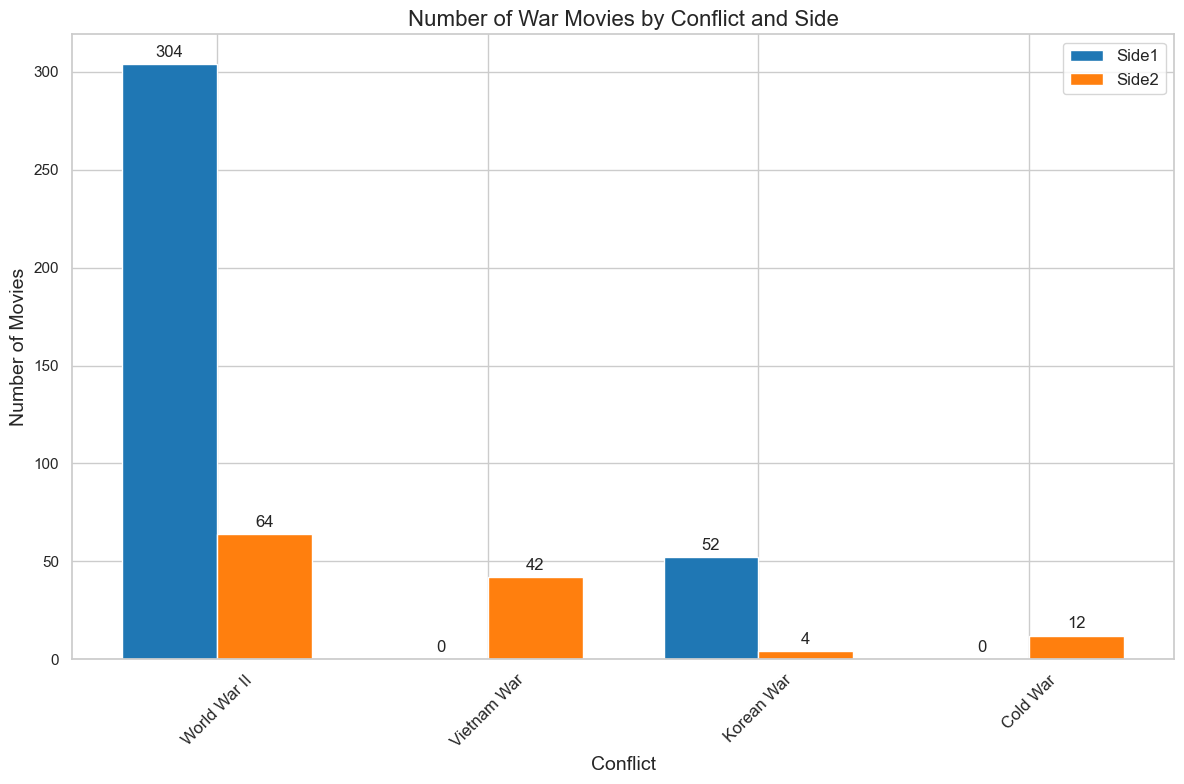

In [22]:
data = {
    'Wars': ['World War II', 'Vietnam War', 'Korean War', 'Cold War'],
    'Side1': [
        wwii_movies_side1.shape[0], 
        vietnam_war_movies_side1.shape[0], 
        korean_war_movies_side1.shape[0], 
        cold_war_movies_side1.shape[0]
    ],
    'Side2': [
        wwii_movies_side2.shape[0], 
        vietnam_war_movies_side2.shape[0], 
        korean_war_movies_side2.shape[0], 
        cold_war_movies_side2.shape[0]  
    ]
}


df_visual = pd.DataFrame(data)

# Set the style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = range(len(df_visual))

# Create bars for Side1 and Side2
bars1 = plt.bar([i - bar_width/2 for i in index], df_visual['Side1'], bar_width, label='Side1', color='#1f77b4')
bars2 = plt.bar([i + bar_width/2 for i in index], df_visual['Side2'], bar_width, label='Side2', color='#ff7f0e')

# Add labels and title
plt.xlabel('Conflict', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.title('Number of War Movies by Conflict and Side', fontsize=16)
plt.xticks(index, df_visual['Wars'], fontsize=12, rotation=45)
plt.legend(fontsize=12)

# Add annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

### Sentiment Analysis
As an example, we conduct an overall sentiment analysis on the Word War II movies to highlight differences in their portrayal. Using the sentiment analyzer, we calculate sentiment scores (negative, neutral, positive, and compound) for the summaries of WWII movies.

In [23]:
# Extract the summaries from the sampled movies
synopses1=wwii_movies_side1["summary"].tolist()
synopses2=wwii_movies_side2["summary"].tolist()

synopses1=cold_war_movies_side1["summary"].tolist()
synopses2=cold_war_movies_side2["summary"].tolist()

In [31]:
# Preprocess the summaries: tokenize and clean the text and Remove stopwords

#WORD WAR II
processed_docs_1 = []
processed_docs_2 = []
for synopsis in synopses1:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_1.append(filtered_tokens)

for synopsis in synopses2:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_2.append(filtered_tokens)

#COLD WAR II

processed_docs_3 = []
processed_docs_4 = []
for synopsis in synopses3:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_3.append(filtered_tokens)

for synopsis in synopses4:
    tokens = word_tokenize(synopsis.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_docs_4.append(filtered_tokens)

NameError: name 'synopses3' is not defined

In [ ]:
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []

####### WORD WAR II ##############

# Analyze the sentiment of each processed summary
for tokens in processed_docs_1:
    text = ' '.join(tokens)
    score = analyzer.polarity_scores(text)
    sentiment_scores.append(score)

sentiment_df_1 = pd.DataFrame(sentiment_scores)
test_sample_1 = wwii_movies_side1.reset_index(drop=True)
test_sample_1 = pd.concat([test_sample, sentiment_df], axis=1)


analyzer_2 = SentimentIntensityAnalyzer()
sentiment_scores_2= []

# Analyze the sentiment of each processed summary
for tokens in processed_docs_2:
    text = ' '.join(tokens)
    score = analyzer_2.polarity_scores(text)
    sentiment_scores_2.append(score)

sentiment_df_2 = pd.DataFrame(sentiment_scores_2)
test_sample_2 = wwii_movies_side2.reset_index(drop=True)
test_sample_2 = pd.concat([test_sample_2, sentiment_df_2], axis=1)


##########COLD WAR################

analyzer_3 = SentimentIntensityAnalyzer()
sentiment_scores_3= []

# Analyze the sentiment of each processed summary
for tokens in processed_docs_3:
    text = ' '.join(tokens)
    score = analyzer.polarity_scores(text)
    sentiment_scores_3.append(score)

sentiment_df_3 = pd.DataFrame(sentiment_scores_3)
test_sample_3 = cold_war_movies_side1.reset_index(drop=True)
test_sample_3 = pd.concat([test_sample_3, sentiment_df_3], axis=1)


analyzer_4 = SentimentIntensityAnalyzer()
sentiment_scores_4= []

# Analyze the sentiment of each processed summary
for tokens in processed_docs_4:
    text = ' '.join(tokens)
    score = analyzer_4.polarity_scores(text)
    sentiment_scores_4.append(score)

sentiment_df_4 = pd.DataFrame(sentiment_scores_2)
test_sample_4 = wwii_movies_side2.reset_index(drop=True)
test_sample_4 = pd.concat([test_sample_4, sentiment_df_4], axis=1)

# Display the summaries along with their sentiment scores
print(test_sample_1[['summary', 'neg', 'neu', 'pos', 'compound']])
print(test_sample_2[['summary', 'neg', 'neu', 'pos', 'compound']])
print(test_sample_3[['summary', 'neg', 'neu', 'pos', 'compound']])
print(test_sample_4[['summary', 'neg', 'neu', 'pos', 'compound']])

# Calcul des moyennes des scores pour chaque ensemble
mean_scores_1 = sentiment_df_1.mean()
mean_scores_2 = sentiment_df_2.mean()
mean_scores_3 = sentiment_df_3.mean()
mean_scores_4 = sentiment_df_4.mean()

print(mean_scores_1)
print(mean_scores_2)
print(mean_score_3) 
print(mean_score_4)

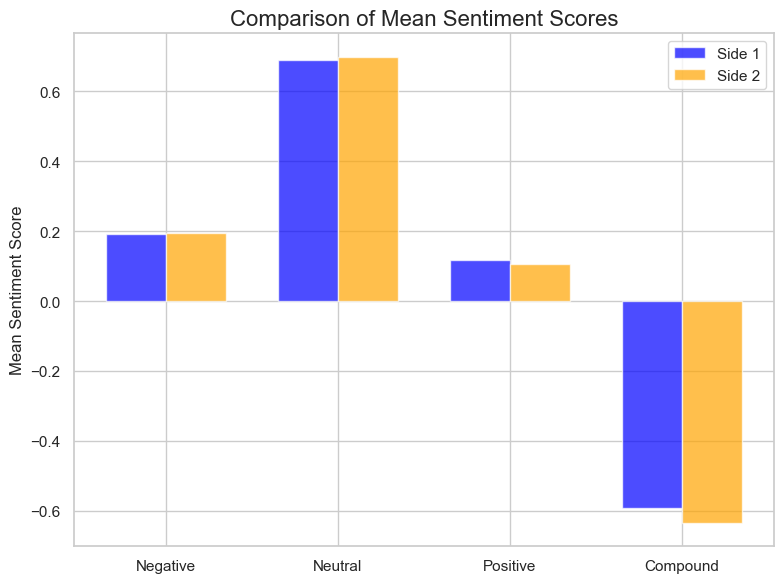

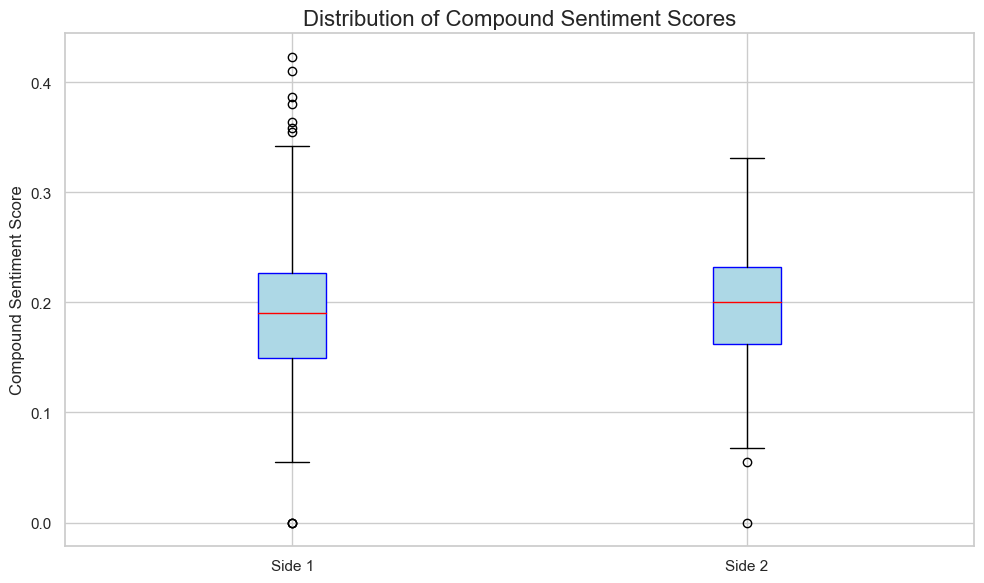

Répartition des tonalités - Side 1:
neu    304
dtype: int64

Répartition des tonalités - Side 2:
neu    64
dtype: int64


In [30]:
# Visualisation 1 : Comparaison des moyennes des scores de sentiment
labels = ['Negative', 'Neutral', 'Positive', 'Compound']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35

ax.bar(x - width/2, mean_scores_1, width, label='Side 1', color='blue', alpha=0.7)
ax.bar(x + width/2, mean_scores_2, width, label='Side 2', color='orange', alpha=0.7)

ax.set_title("Comparison of Mean Sentiment Scores", fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Mean Sentiment Score", fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

# Visualisation 2 : Distribution des scores 'compound' avec des boxplots
fig, ax = plt.subplots(figsize=(10, 6))
data = [sentiment_df_1['neg'], sentiment_df_2['neg']]
ax.boxplot(data, vert=True, patch_artist=True, labels=['Side 1', 'Side 2'],
           boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'))

ax.set_title("Distribution of Compound Sentiment Scores", fontsize=16)
ax.set_ylabel("Compound Sentiment Score", fontsize=12)
plt.tight_layout()
plt.show()

print("Répartition des tonalités - Side 1:")
print(side1_sentiment_counts)
print("\nRépartition des tonalités - Side 2:")
print(side2_sentiment_counts)



#### displaying results

In [ ]:
# Prepare data for visualization
sentiment_analysis_viz = test_sample[['Countries', 'neg', 'pos', 'neu']]
sentiment_analysis_viz['Countries'] = sentiment_analysis_viz['Countries'].apply(ast.literal_eval)

# Calculate the mean negative,neutral and positive sentiment score per country
neg_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['neg'].mean()).reset_index()
pos_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['pos'].mean()).reset_index()
neu_by_countries = pd.DataFrame(sentiment_analysis_viz.explode('Countries').groupby('Countries')['neu'].mean()).reset_index()

## Sentiment Scores per Country 
We decided to focus on Japan, the USA, and Germany, as these countries likely experienced the conflict in fundamentally different ways.

In [ ]:
# Extract sentiment data for the USA, Japan and Germany
data_usa = [neg_by_countries.loc[neg_by_countries['Countries'] == 'United States of America']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'United States of America']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'United States of America']['neu']]
data_japan = [neg_by_countries.loc[neg_by_countries['Countries'] == 'Japan']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'Japan']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'Japan']['neu']]
data_germany = [neg_by_countries.loc[neg_by_countries['Countries'] == 'German Democratic Republic']['neg'], pos_by_countries.loc[pos_by_countries['Countries'] == 'German Democratic Republic']['pos'], neu_by_countries.loc[neu_by_countries['Countries'] == 'German Democratic Republic']['neu']]

# Organize the sentiment data into a dictionary for plotting
score = ("Negative", "Neutral", "Positive")
sentiment_means = {
    'USA': (data_usa[0].values.item(), data_usa[1].values.item(), data_usa[2].values.item()),
    'Germany': (data_germany[0].values.item(), data_germany[1].values.item(), data_germany[2].values.item()),
    'Japan': (data_japan[0].values.item(), data_japan[1].values.item(), data_japan[2].values.item()),
}

# Plot the sentiment scores for each country
x = np.arange(len(score))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in sentiment_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Sentiment Score')
ax.set_title('Sentiment scores per Country')
ax.set_xticks(x + width, score)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)

plt.show()

### 

### Named Entity recognition

We perform Named Entity Recognition (NER) to extract key roles in the synopses. This allows us to connect sentiment analysis results to the main figures or groups depicted in the films. Hence, we can better understand public opinion on these characters or figures and how they are portrayed in the context of major conflicts.


In [ ]:
##  Defining the function used in the anaylysis 

# Extracting entities corresponding to organizations from the NER tags
def extracting_entities(tree):
    # Initializing the entities 
    entities = []
    for subtree in tree.subtrees():
        # If the label of subtree corresponds to an organization, append its leaves (the names) to the entities list
        if (subtree.label() == 'ORGANIZATION'):
            entities.append(" ".join(word for word, tag in subtree.leaves()))
    return entities



# Defining a function to extract sentiment scores per entity
def entity_sentiment_analysis(summary, entities, country):
    # Initialization of the variables used 
    global average_sentiment
    entities_sentiment = []
    # Tokenizing the summary by sentences 
    sent = sent_tokenize(summary)
    
    for entity in entities:
        # Extracting the sentences that contain a specific entity, and obtaining the sentiment score of all of these sentences
        entity_sentences = [sentence for sentence in sent if entity in sentence]
        sentiment_scores = [analyzer.polarity_scores(sentence) for sentence in entity_sentences]

        if sentiment_scores:
            #Computing the average compound score for the entity, and creating 
            average_sentiment = {
                'Entity' : entity,
                'Country': country,
                'Compound' : sum([score['compound'] for score in sentiment_scores])/len(sentiment_scores),
            }
        entities_sentiment.append(average_sentiment)

    return entities_sentiment

In [ ]:
# Tokenize the summaries for NER processing
wwii_movies['tokenized_summaries'] = wwii_movies['summary'].apply(word_tokenize)
cold_war_movies['tokenized_summaries'] = cold_war_movies['summary'].apply(word_tokenize)
korean_war_movies['tokenized_summaries'] = korean_war_movies['summary'].apply(word_tokenize)
vietnam_war_movies['tokenized_summaries'] = vietnam_war_movies['summary'].apply(word_tokenize)

In [ ]:
# Initializing variables necessary for iteration over all of the conflicts
wars_iterator = [wwii_movies, cold_war_movies, korean_war_movies, vietnam_war_movies]
war_names = ['World War II', "Cold War", "Korean war", "Vietnan war"]

# Initializing stop words and Lemmatizer for data processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


In [ ]:
# Extracting the NER tags from each  summary

full_NER_TAGS = [[], [], [], []]
for i, test_sample in enumerate(wars_iterator):
    # Preprocess the text,tokenize, clean and remove stopwords
    tokens_summ = test_sample['tokenized_summaries'].to_list()
    NER_tags = []
    for summary in tokens_summ:
        filtered_token = [word for word in summary if word not in stop_words]
        lemmatized_tokens = ([lemmatizer.lemmatize(token) for token in filtered_token])
        pos_tags = nltk.pos_tag(lemmatized_tokens)
        # Perform NER chunking to identify named entities
        ner_tags = ne_chunk(pos_tags)
        NER_tags.append(ner_tags)

    full_NER_TAGS[i] = NER_tags
    

In [ ]:
# Displaying one tag for verification 
full_NER_TAGS[1][0]

In [ ]:
# Extracting entities 
full_entities = [[], [], [], []]
for i, tags in enumerate(full_NER_TAGS): 
    entities = []
    for tree in tags:
        entities.append(extracting_entities(tree))
    full_entities[i] = entities 

In [ ]:
# Creating a new column in each movies dataset containing the entities
wwii_movies['Entities'] = full_entities[0]
cold_war_movies['Entities'] = full_entities[1]
korean_war_movies['Entities'] = full_entities[2]
vietnam_war_movies['Entities'] = full_entities[3]

# Verification
wwii_movies.head()

### Entity-level sentiment analysis

In [ ]:
# Perform entity-level sentiment analysis on every conflict's subset of movies
for i, test_sample in enumerate(wars_iterator):
    # Create a new dataframe for analysis
    summaries = test_sample[['summary', 'Entities', 'Countries']]

    # Perform the entity-level analysis on each row of the dataset and appending it in the results table
    results = []
    for _, row in summaries.iterrows():
        sentiments = entity_sentiment_analysis(row["summary"], row["Entities"], row['Countries'])
        results.extend(sentiments)

    # Convert results to a DataFrame
    entity_sentiments_df = pd.DataFrame(results)

    # TODO: maybe delete this ? 
    sentiment = []
    for j in range(len(entity_sentiments_df)):
        if entity_sentiments_df.iloc[j, 2] >= 0.05:
            sentiment.append('Protagonist')
        elif entity_sentiments_df.iloc[j, 2] <= -0.05:
            sentiment.append('Antagonist')
        else:
            sentiment.append('Protagonist')

    # Create a new column for the role of the entity (Protagonist or Antagonist) and drop the duplicates 
    entity_sentiments_df['Sentiment'] = sentiment
    entity_sentiments_df.drop_duplicates(inplace=True)
    entity_sentiments_df['Country'] = entity_sentiments_df['Country'].apply(literal_eval)

    # Explode the dataframe on the country column in order to analyse country-wise
    entity_sentiments_df_exploded = entity_sentiments_df.explode("Country").reset_index(drop=True)

    # Initializing the heatmap data by pivoting the dataframe on the "Country" column
    heatmap_data = entity_sentiments_df_exploded.pivot_table(index="Entity", columns="Country", values="Compound")

    ## Data Visualitation

    # Create the initial heatmap (first frame)
    frames = []
    first_side_data = entity_sentiments_df_exploded[entity_sentiments_df_exploded["Country"].isin(wwii_bell_side1)]
    frames.append(go.Frame(
            data=[go.Heatmap(
                z=first_side_data["Compound"],
                x=first_side_data["Country"],
                y=first_side_data["Entity"],
                colorscale="RdBu"
            )],
            name = 'Side 1'
        ))
    second_side_data = entity_sentiments_df_exploded[entity_sentiments_df_exploded["Country"].isin(wwii_bell_side2)]
    frames.append(go.Frame(
            data=[go.Heatmap(
                z=second_side_data["Compound"],
                x=second_side_data["Country"],
                y=second_side_data["Entity"],
                colorscale="RdBu"
            )],
            name = 'Side 2'
        ))

    heatmap = go.Heatmap(
        z=[first_side_data["Compound"]],
        x=first_side_data["Country"],
        y=first_side_data["Entity"],
        colorscale="RdBu",
        colorbar=dict(title="Sentiment Score")
    )

    # Create Figure
    fig = go.Figure(
        data=[heatmap],  # Initial data
        frames=frames    # Add all frames for animation
    )

    # Update Layout with Slider
    fig.update_layout(
        title=f"Sentiment Score Heatmap of {war_names[i]}",
        sliders=[{
            "steps": [
                {"args": [[frame.name]],
                "label": frame.name,
                "method": "animate"}
                for frame in frames
            ],
            "transition": {"duration": 500},
        }],

    )

    # Show Figure
    fig.show()


## 4. Research Question 4

How do global events, such as natural disasters, pandemics, wars, and economic downturns, influence public preferences for certain movie thematics?

### 4.0 Fetch and graph Google Search Trends: Example

In [ ]:
# Define the search query
query = "war movies"

In [ ]:
# Find interest for a given query over all time
df = gt.query_full_interest(query)
df.head(20)

In [ ]:
# Plot the interest over time for a given query
gt.plot_interest_time_series(df, query)

In [ ]:
# Find interest for a given query around a specific date
df_partial = gt.query_interest_around_date(query, '2021-01-01')
df_partial.head(20)

In [ ]:
# Plot the interest over time for a given query around a specific date
gt.plot_interest_time_series(df_partial, query, '2021-01-01', 'some event')

### 4.1 Wikidata Events timeline

In [ ]:
df_events = pd.read_csv('data/events.csv')
df_events['date'] = pd.to_datetime(df_events['date'])
df_events.head()

In [ ]:
df_events['event_type'].value_counts()

In [ ]:
# Graph the number of events by type
plt.figure(figsize=(12, 6))
sns.countplot(data=df_events, x='event_type', order=df_events['event_type'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Number of events by type')
plt.show()

In [ ]:
# Plot the event types by year
df_year = df_events.copy()
df_year['year'] = df_year['date'].dt.year

# Group by year and event type, and count occurrences
df_grouped = df_year.groupby(['year', 'event_type']).size().reset_index(name='count')

# Pivot to get data in wide format for stacking
df_pivot = df_grouped.pivot(index='year', columns='event_type', values='count').fillna(0)

# Plot the stacked bar chart
ax = df_pivot.plot(kind='bar', stacked=True, figsize=(20, 10), cmap='tab10')

plt.title("Event Types by Year")
plt.xlabel("Year")
plt.ylabel("Number of Events")
plt.legend(title="Event Type")
plt.tight_layout()

### 4.2 Google Search Trends: Case Study

In [ ]:
# Sample some events marked as catastrophic
df_catastrophic = df_events[df_events['event_type'] == 'catastrophe']

pd.set_option('display.max_colwidth', None)
df_catastrophic.tail(30)

In [ ]:
# Select one event
event_date = "2020-01-08"
event_name = "Ukrainian Boeing 737 Crash"
keyword = "plane crash movies"

In [ ]:
# Query Google Trends for interest around the event date
df_event = gt.query_interest_around_date(keyword, event_date)

# Plot the interest over time
gt.plot_interest_time_series(df_event, keyword, event_date, event_name)

We can clearly observe an impact of interest for "plane crash movies" just after the worldwide news of a large plane crash. This can be applied to multiple events, either to see short-time trends or long-time evolution of trends.